# Node Operations

To form a large network, you need to know the supported node operations. In this section, we are going to talk about this. 

In [1]:
import brainpy as bp
import brainpy.math as bm

# bm.set_platform('cpu')

The Node instance supports the following basic node operations:

1. feedforward connection: ``>>``,  ``>>=``
2. feedback connection: ``<<``, ``<<=``
3. merging: ``&`` or ``&=``
4. concatenating: ``[node1, node2, ...]`` or ``(node1, node2, ...)``
5. wraping a set of nodes: ``{node1, node2, ...}``
6. selection: ``node[slice]`` (like "node[1, 2, 3]", "node[:10]")

## Feedforward operator

Feedforward connection is the theme of the network construction. To declare a feedforward connection between two nodes, you can use the ``>>`` operator.

Users can use ``node1 >> node2`` to create a feedforward connection betweem two nodes. Or, ones can use ``node1 >>= node2`` to in-place connect ``node2``. 

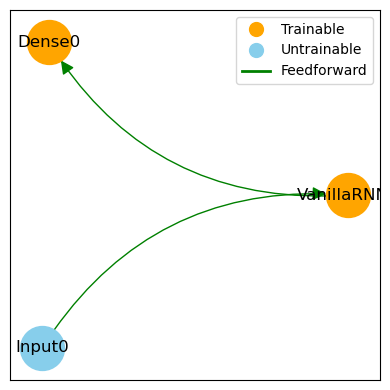

In [2]:
i = bp.nn.Input(1)
r = bp.nn.VanillaRNN(10)
o = bp.nn.Dense(1)

model = i >> r >> o

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

Nodes can be combined in any way to create deeper structure. The ``>>`` operator allows to compose nodes to form a sequential model. Data flows from node to node in a sequence. Below are examples of deep recurrent neural networks. 

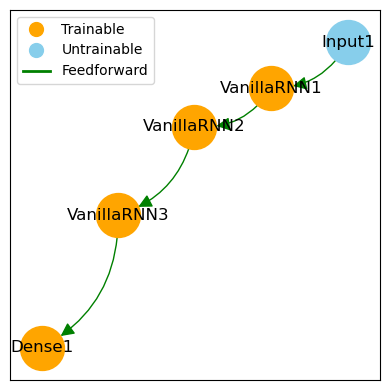

In [3]:
model = (
    bp.nn.Input(1)
    >>
    bp.nn.VanillaRNN(10)
    >>
    bp.nn.VanillaRNN(20)
    >>
    bp.nn.VanillaRNN(10)
    >>
    bp.nn.Dense(1)
)

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

```{note}

The feedforward connections cannot form a cycle. Otherwise, an error will be raised. 

```

In [4]:
try:
    model = i >> r >> o >> i
except Exception as e:
    print(f'{e.__class__.__name__}: {e}')

ValueError: We detect cycles in feedforward connections. Maybe you should replace some connection with as feedback ones.


## Feedback operator

Feedback connections are important features of reservoir computing. Once a feedback connection is established between two nodes, when running on a timeseries, BrainPy will allow the receiver to access the state of the sender, with a time delay of one timestep (however this can be customized by user settings). 

To declare a feedback connection between two nodes, you can use the ``<<`` operator. 

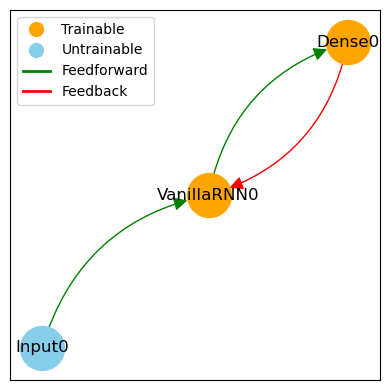

In [5]:
model = (i >> r >> o) & (r << o)

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

## Merging operator

The merging ``&`` operator allows to merge models together. Merging two networks will create a new network model containing all nodes and all conenction edges in the two networks. 

Some networks may have input-to-readout connections. This can be achieved using the merging operation ``&``.

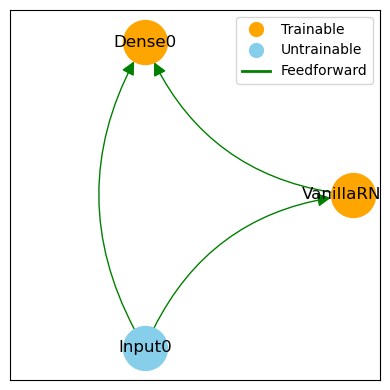

In [6]:
model = (i >> r >> o) & (i >> o)

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

## Concatenating operator 

Concatenating operators ``[]`` and ``()`` will concatenate multiple nodes into one. It can be used in the sender side of a feedforward or feedback connection. 

For above input-to-readout connections, we can rewrite it as:


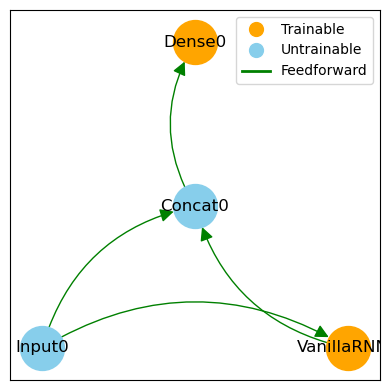

In [7]:
model = [i >> r, i] >> o
# or  
# model = (i >> r, i) >> o

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

```{note}

Concatenating multiple nodes in the receiver side will cause errors. 
```

In [8]:
# In the above network, "i" project to "r" and "o" simultaneously.
# However, we cannot express this node graph as
#
#    i >> [r, o]

try:
    model = i >> [r, o]
except Exception as e:
    print(f'{e.__class__.__name__}: {e}')

ValueError: Cannot concatenate a list/tuple of receivers. Please use set to wrap multiple receivers instead.


## Wraping operator

Wrapping a set of nodes ``{}`` means that these nodes are equal and they can make the same operation simultaneously. 

For example, if the input node "i" project to recurrent node "r" and readout node "o" simultaneously, we can express this graph as 

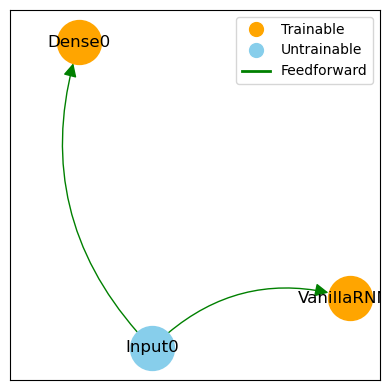

In [9]:
model = i >> {r, o}

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

Similarly, if multiple nodes connect to a same node, we can wrap then first and then establish the connections. 

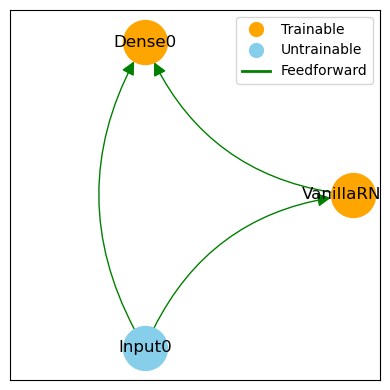

In [10]:
model = {i >> r, i} >> o

model.plot_node_graph(fig_size=(4, 4), node_size=1000)

## Selecting operator

Sometimes, our input is just a subset of output of a node. For this situation, we can use selection ``node[]`` operator. 

For example, if we want decode a half of output of the recurrent node "r" by a readout node, and decode the other half of recurrent output by another readout node, we can express this graph as:

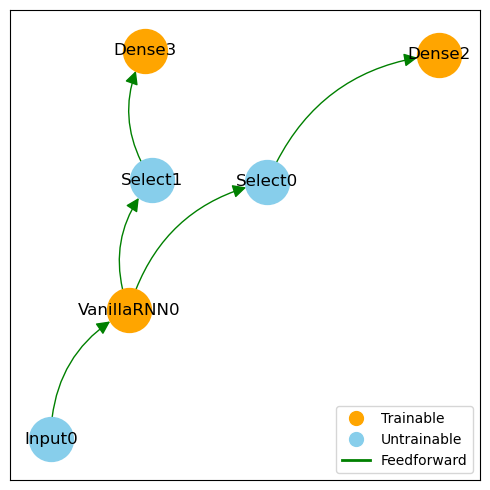

In [11]:
o1 = bp.nn.Dense(1)
o2 = bp.nn.Dense(2)

model = i >> r
model = (model[:, :5] >> o1)  & (model[:, 5:] >> o2) # the first is the batch axis

model.plot_node_graph(fig_size=(5, 5), node_size=1000)